In [3]:
pip install ta

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install requests pandas numpy matplotlib ta

Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install pandas numpy matplotlib scikit-learn requests scipy SQLAlchemy


Fetching data for Bitcoin...
Fetched 91 records for Bitcoin.

Fetching data for Ethereum...
Fetched 91 records for Ethereum.

Fetching data for Litecoin...
Fetched 91 records for Litecoin.

Processing Bitcoin...


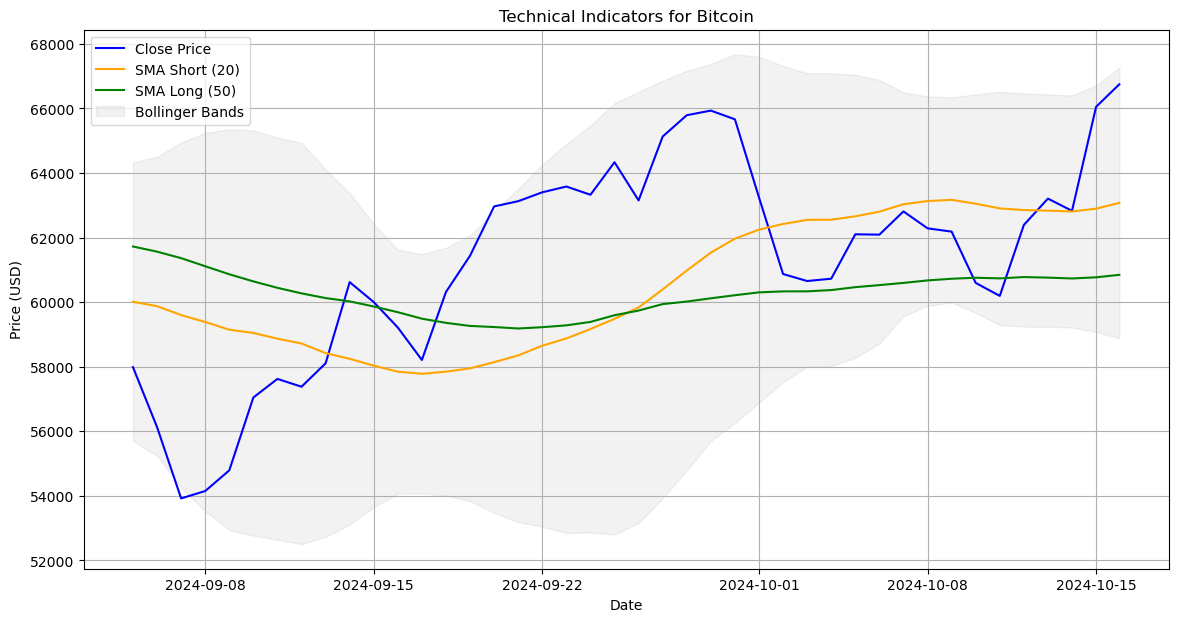

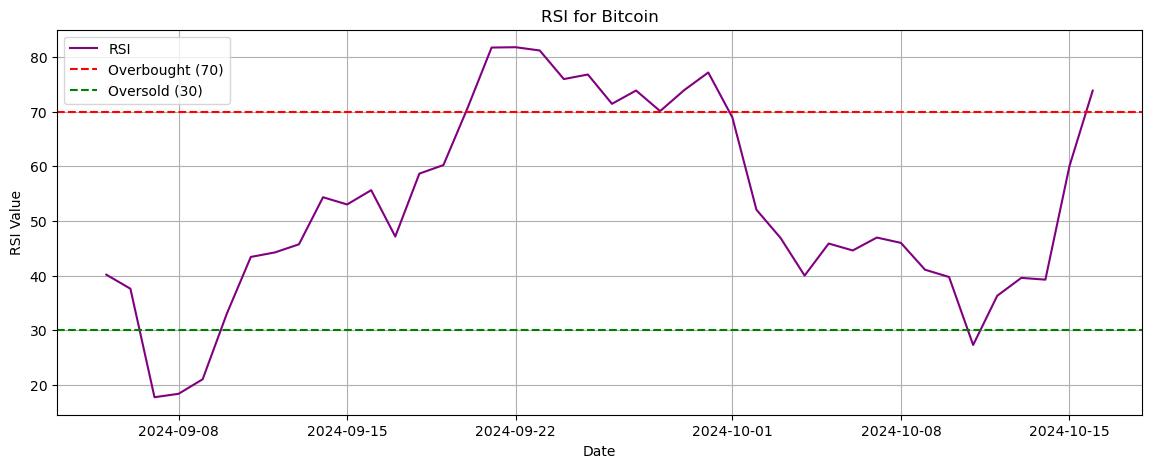

Data for Bitcoin saved to bitcoin_forecast_rates.csv
Data for Bitcoin saved to SQL database.
Not enough data to generate forecast for Bitcoin.

Processing Ethereum...


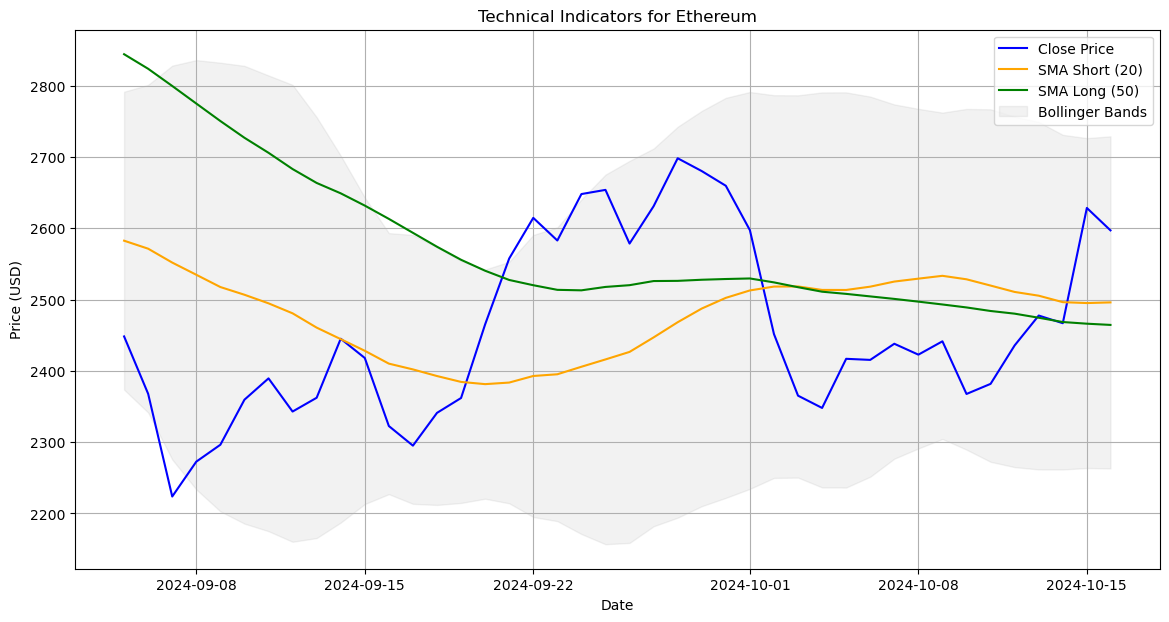

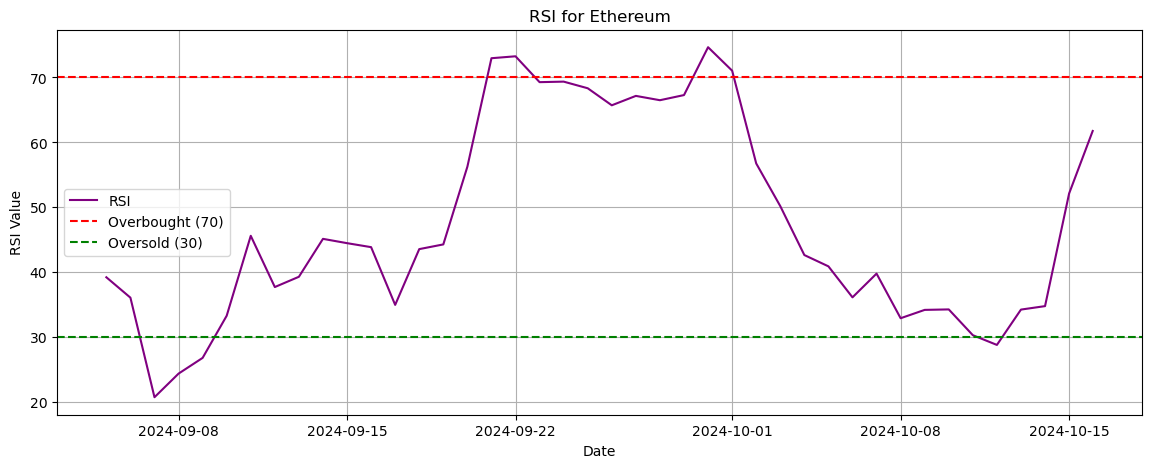

Data for Ethereum saved to ethereum_forecast_rates.csv
Data for Ethereum saved to SQL database.
Not enough data to generate forecast for Ethereum.

Processing Litecoin...


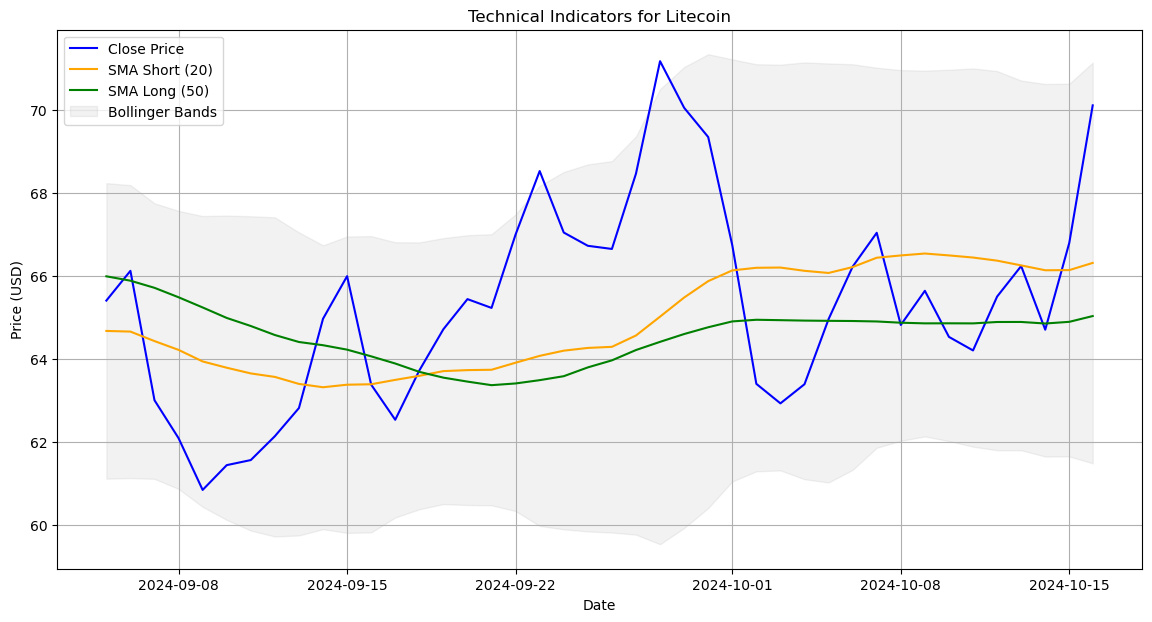

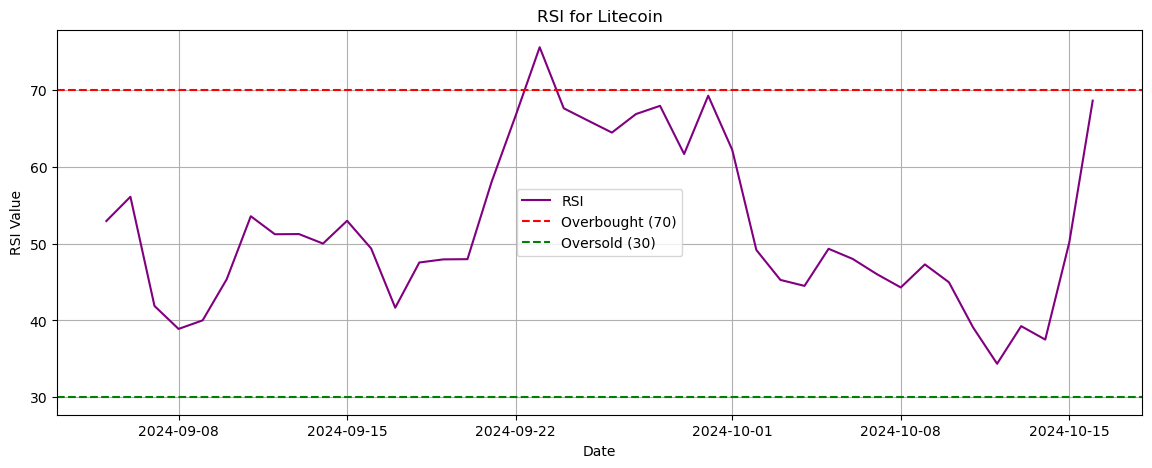

Data for Litecoin saved to litecoin_forecast_rates.csv
Data for Litecoin saved to SQL database.
Not enough data to generate forecast for Litecoin.
Exchange rates exported to SQL database.

Combined Crypto Data:
           Cryptocurrency         Close
Date                                   
2024-07-18        bitcoin  64136.313844
2024-07-19        bitcoin  63959.569008
2024-07-20        bitcoin  66689.548807
2024-07-21        bitcoin  67206.064706
2024-07-22        bitcoin  68088.139963
Combined crypto data exported to SQL database.

All tasks completed successfully.


In [49]:
import hashlib
import requests
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from sqlalchemy import create_engine
import pyodbc
from statsmodels.tsa.arima.model import ARIMA  # Added Import for ARIMA

# =========================
# Configuration and Settings
# =========================
# Cryptocurrencies to analyze with correct CoinGecko IDs
cryptocurrencies = {
    'bitcoin': 'bitcoin',
    'ethereum': 'ethereum',
    'litecoin': 'litecoin'
}

# Technical Indicators Settings
SMA_SHORT = 20
SMA_LONG = 50
RSI_PERIOD = 14
PREDICTION_DAYS = 7  # Number of days to forecast

# SQL Database Configuration
# Update the connection string to connect to your SQL Server instance "MARTIN" and database "crypto_data"
# Using trusted_connection (Windows Authentication). If using SQL Server Authentication, include username and password.
DATABASE_TYPE = 'mssql'  # Microsoft SQL Server
DBAPI = 'pyodbc'
SERVER = 'MARTIN'  # Your SQL Server instance name
DATABASE = 'crypto_data'  # Your target database name
DRIVER = 'ODBC Driver 17 for SQL Server'  # Ensure this driver is installed

# Create SQLAlchemy engine
# For Windows Authentication
DATABASE_URI = f"{DATABASE_TYPE}+{DBAPI}://@{SERVER}/{DATABASE}?driver={DRIVER.replace(' ', '+')}&trusted_connection=yes"
# If using SQL Server Authentication, uncomment and update the following lines:
# USERNAME = 'your_username'
# PASSWORD = 'your_password'
# DATABASE_URI = f"{DATABASE_TYPE}+{DBAPI}://{USERNAME}:{PASSWORD}@{SERVER}/{DATABASE}?driver={DRIVER.replace(' ', '+')}"
engine = create_engine(DATABASE_URI, echo=False)

# =========================
# Utility Functions
# =========================
def get_hash(data):
    """Generates a SHA-256 hash for the given data."""
    hash_object = hashlib.sha256(data.encode())
    return hash_object.hexdigest()

# =========================
# Data Fetching Functions
# =========================
def fetch_crypto_data(crypto_id, vs_currency='usd', days='60'):
    """Fetches historical market data for a cryptocurrency from CoinGecko."""
    url = f'https://api.coingecko.com/api/v3/coins/{crypto_id}/market_chart'
    params = {
        'vs_currency': vs_currency,
        'days': days,
        'interval': 'daily'
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        if 'prices' not in data:
            print(f"Error: 'prices' key not found in the response for '{crypto_id}'. Response: {data}")
            return pd.DataFrame()

        # Convert to DataFrame
        prices = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
        prices['Date'] = pd.to_datetime(prices['timestamp'], unit='ms')
        prices.set_index('Date', inplace=True)
        prices['Close'] = prices['price']
        prices = prices[['Close']].sort_index()

        # Optional: Generate Hash (if needed)
        # prices['Hash'] = prices['Close'].apply(lambda x: get_hash(str(x)))

        return prices

    except requests.exceptions.RequestException as e:
        print(f"CoinGecko API error for '{crypto_id}': {e}")
        return pd.DataFrame()

def fetch_all_crypto_data():
    """Fetches historical data for all specified cryptocurrencies."""
    crypto_data = {}
    for crypto_name, crypto_id in cryptocurrencies.items():
        print(f"\nFetching data for {crypto_name.capitalize()}...")
        prices = fetch_crypto_data(crypto_id, days='90')  # Fetching last 90 days as per original script
        if prices.empty:
            print(f"No data available for {crypto_name.capitalize()}. Skipping...")
            continue
        crypto_data[crypto_name] = prices
        print(f"Fetched {len(prices)} records for {crypto_name.capitalize()}.")
    return crypto_data

# =========================
# Technical Analysis Functions
# =========================
def perform_technical_analysis(df):
    """Applies technical indicators to the DataFrame."""
    df = df.copy()
    df['SMA_Short'] = df['Close'].rolling(window=SMA_SHORT).mean()
    df['SMA_Long'] = df['Close'].rolling(window=SMA_LONG).mean()
    df['RSI'] = compute_rsi(df['Close'], window=RSI_PERIOD)
    df['Bollinger_High'], df['Bollinger_Low'] = compute_bollinger_bands(df['Close'], window=20, window_dev=2)
    
    # Drop rows with NaN values in any of the technical indicators
    df.dropna(subset=['SMA_Short', 'SMA_Long', 'RSI', 'Bollinger_High', 'Bollinger_Low'], inplace=True)
    
    return df

def compute_rsi(series, window=14):
    """Computes the Relative Strength Index (RSI) for a given series."""
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

def compute_bollinger_bands(series, window=20, window_dev=2):
    """Computes Bollinger Bands for a given series."""
    rolling_mean = series.rolling(window).mean()
    rolling_std = series.rolling(window).std()
    upper_band = rolling_mean + (rolling_std * window_dev)
    lower_band = rolling_mean - (rolling_std * window_dev)
    return upper_band, lower_band

def identify_trends(df):
    """Identifies upward and downward trends based on technical indicators."""
    df = df.copy()
    df['Trend'] = 'Neutral'
    df.loc[df['SMA_Short'] > df['SMA_Long'], 'Trend'] = 'Uptrend'
    df.loc[df['SMA_Short'] < df['SMA_Long'], 'Trend'] = 'Downtrend'
    df['RSI_Status'] = 'Neutral'
    df.loc[df['RSI'] > 70, 'RSI_Status'] = 'Overbought'
    df.loc[df['RSI'] < 30, 'RSI_Status'] = 'Oversold'
    return df

# =========================
# Forecasting Function
# =========================
def generate_forecast(df, crypto_name, prediction_days=PREDICTION_DAYS):
    """Generates a forecast using ARIMA model."""
    # Ensure there is enough data
    if len(df) < SMA_LONG:  # At least as many data points as the longest moving average window
        print(f"Not enough data to generate forecast for {crypto_name.capitalize()}.")
        return

    # Prepare the data for the ARIMA model
    df = df.copy()
    df['Close'] = df['Close'].astype(float)  # Ensure 'Close' is in float

    # Infer or set the frequency for the date index
    if df.index.freq is None:
        df = df.asfreq('D')  # Set to daily frequency ('D')
    
    # Handle missing data after setting frequency
    df = df.fillna(method='ffill')
    
    # Fit the ARIMA model
    try:
        model = ARIMA(df['Close'], order=(5, 1, 0))  # ARIMA(p=5, d=1, q=0)
        model_fit = model.fit()
    except Exception as e:
        print(f"ARIMA model failed for {crypto_name.capitalize()}: {e}")
        return

    # Forecast future prices
    try:
        forecast = model_fit.forecast(steps=prediction_days)
    except Exception as e:
        print(f"Forecasting failed for {crypto_name.capitalize()}: {e}")
        return
    
    # Set forecast dates with proper frequency
    forecast_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=prediction_days, freq='D')

    # Plot forecast
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Historical Close', color='blue')
    plt.plot(forecast_dates, forecast, label=f'{crypto_name.capitalize()} Forecast', color='red', linestyle='--')
    plt.title(f"{crypto_name.capitalize()} Price Forecast for Next {prediction_days} Days")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid()
    plt.show()

    # Calculate and print the RMSE (Root Mean Squared Error)
    try:
        history_len = len(df['Close'])
        prediction_len = min(history_len, 30)  # Take the last 30 data points for RMSE calculation
        past_values = df['Close'].values[-prediction_len:]
        predictions = model_fit.predict(start=history_len - prediction_len, end=history_len - 1)
        rmse = np.sqrt(mean_squared_error(past_values, predictions))
        print(f"RMSE for {crypto_name.capitalize()}: {rmse}")
    except Exception as e:
        print(f"RMSE calculation failed for {crypto_name.capitalize()}: {e}")

    # Export forecast to SQL Database
    try:
        forecast_df = pd.DataFrame({
            'Date': forecast_dates,
            'Predicted_Price': forecast.values,
            'Crypto': crypto_name.capitalize()
        })
        forecast_df.to_sql('crypto_forecasts', con=engine, if_exists='append', index=False)
        print(f'Future predictions for {crypto_name.capitalize()} exported to SQL database.')
    except Exception as e:
        print(f"Failed to export forecast for {crypto_name.capitalize()} to SQL database: {e}")

# =========================
# Additional Functions
# =========================
def plot_technical_indicators(df, crypto_name):
    """Plots the technical indicators for the given cryptocurrency."""
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Close Price', color='blue')
    plt.plot(df.index, df['SMA_Short'], label=f'SMA Short ({SMA_SHORT})', color='orange')
    plt.plot(df.index, df['SMA_Long'], label=f'SMA Long ({SMA_LONG})', color='green')
    plt.fill_between(df.index, df['Bollinger_Low'], df['Bollinger_High'], color='grey', alpha=0.1, label='Bollinger Bands')
    plt.title(f"Technical Indicators for {crypto_name.capitalize()}")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid()
    plt.show()

def plot_rsi(df, crypto_name):
    """Plots the RSI for the given cryptocurrency."""
    plt.figure(figsize=(14, 5))
    plt.plot(df.index, df['RSI'], label='RSI', color='purple')
    plt.axhline(70, linestyle='--', color='red', label='Overbought (70)')
    plt.axhline(30, linestyle='--', color='green', label='Oversold (30)')
    plt.title(f"RSI for {crypto_name.capitalize()}")
    plt.xlabel("Date")
    plt.ylabel("RSI Value")
    plt.legend()
    plt.grid()
    plt.show()

def fetch_exchange_rates():
    """Fetches exchange rates for cryptocurrencies against FIAT currencies and exports to SQL."""
    FIAT_CURRENCIES = ['usd', 'eur', 'jpy', 'gbp', 'aud']  # Use lowercase for CoinGecko
    url = 'https://api.coingecko.com/api/v3/simple/price'
    crypto_ids = ','.join(cryptocurrencies.values())
    params = {
        'ids': crypto_ids,
        'vs_currencies': ','.join(FIAT_CURRENCIES)
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        # Convert the response to a DataFrame
        exchange_rates = pd.json_normalize(data).T.reset_index()

        # Dynamically adjust columns based on the number of currencies retrieved
        fiat_columns = ['Crypto'] + FIAT_CURRENCIES[:len(exchange_rates.columns) - 1]
        exchange_rates.columns = fiat_columns

        exchange_rates['Crypto'] = exchange_rates['Crypto'].str.capitalize()

        # Export to SQL Database
        exchange_rates.to_sql('exchange_rates', con=engine, if_exists='append', index=False)
        print('Exchange rates exported to SQL database.')

        return data
    except requests.exceptions.RequestException as e:
        print(f"CoinGecko API error while fetching exchange rates: {e}")
        return None

def display_data_as_table(data_dict):
    """Displays the dataset as a table and exports to SQL Database."""
    # Concatenate all DataFrames into a single DataFrame for display
    combined_df = pd.concat(data_dict.values(), keys=data_dict.keys())
    combined_df = combined_df.reset_index(level=0).rename(columns={'level_0': 'Cryptocurrency'})
    print("\nCombined Crypto Data:")
    print(combined_df.head())

    # Export combined data to SQL Database
    combined_df.reset_index(inplace=True)
    combined_df.rename(columns={'level_0': 'Cryptocurrency'}, inplace=True)
    try:
        combined_df.to_sql('crypto_prices', con=engine, if_exists='append', index=False)
        print('Combined crypto data exported to SQL database.')
    except Exception as e:
        print(f"Failed to export combined crypto data to SQL database: {e}")

# =========================
# Main Execution Flow
# =========================
if __name__ == "__main__":
    # Fetch all crypto data
    all_crypto_data = fetch_all_crypto_data()

    # Perform technical analysis, forecasting, plotting, and exporting to SQL
    for crypto, df in all_crypto_data.items():
        print(f"\nProcessing {crypto.capitalize()}...")
        analyzed_df = perform_technical_analysis(df)
        trend_identified_df = identify_trends(analyzed_df)

        # Plotting the technical indicators and RSI
        plot_technical_indicators(trend_identified_df, crypto)
        plot_rsi(trend_identified_df, crypto)

        # Save to CSV for each cryptocurrency
        csv_filename = f"{crypto}_forecast_rates.csv"
        trend_identified_df.to_csv(csv_filename)
        print(f"Data for {crypto.capitalize()} saved to {csv_filename}")

        # Save the CSV data to SQL database
        try:
            # Read the CSV file back into a DataFrame (optional, can use trend_identified_df directly if no CSV needed)
            csv_data_df = pd.read_csv(csv_filename)

            # Insert the data into the SQL database
            csv_data_df.to_sql('crypto_trend_data', con=engine, if_exists='append', index=False)
            print(f"Data for {crypto.capitalize()} saved to SQL database.")
        except Exception as e:
            print(f"Failed to save {crypto.capitalize()} data to SQL database: {e}")

        # Forecast the cryptocurrency price for the next PREDICTION_DAYS
        generate_forecast(trend_identified_df, crypto, prediction_days=PREDICTION_DAYS)

    # Fetch exchange rates once for all cryptocurrencies
    fetch_exchange_rates()

    # Display the fetched data as a table and export to SQL
    display_data_as_table(all_crypto_data)

    print("\nAll tasks completed successfully.")